# Setup

In [3]:
!pip install pykalman

In [4]:
%load_ext google.colab.data_table
# %unload_ext google.colab.data_table
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import bisect
import math
import sys
import seaborn as sns
from datetime import datetime
from pykalman import KalmanFilter

sns.set(rc={'figure.figsize':(15, 15)})

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# New Section

# Utility Functions

In [0]:
def add_freq(df):
    """
    Adds time offset based on number of readings at each second
    Input:
    ====== 
    df: Sensor dataset 

 
    Output
    ======
    df: DataFrame with offset added to timestamp value
    
    """

    offsets = np.array([])
    # Creating offsets for each time value
    for freq in df.groupby("timestamp").count()['x']:
        offsets = np.append(offsets,np.linspace(0,1,freq))
    df["offset"] = offsets
    # Converting offsets to datetime format to allow addition to timestamp 
    df["offset"] = df.offset.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x))
    # Adding offset to timestamp value
    df["timestamp"] = df["timestamp"] + df["offset"]
    df = df.drop('offset',axis=1)
    return df


# This function creates "frames" by default
def convert_to_timeseries(df,offset = False):
    """
    Converts sensor dataframe to timeseries data. Each second represents a frame.
    """
    if 'timestamp' in df:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        if offset:
            df = add_freq(df)
        df = df.set_index('timestamp')
    return df

def preprocess_truth(df,time,keepNA = True):
    """
    Removes additional data from the "Truth" Dataframe and adds offset to Start time to align it with Actual trip time
    Input:
    ======
    df: Ground truth dataframe
    time: Start time of the trip
    keepNA: Boolean telling if Non Aggressive maneuvers should be removed or not
    
    Output
    ======
    maneuvers: DataFrame containing maneuvers and their actual start times.
    
    """

    # Removes Non-Aggressive maneuvers from the dataset
    maneuvers = df[df["Event"] != "Non-aggressive event"].iloc[:,:2]
    
    if keepNA:
        maneuvers = df.iloc[:,:2]

    maneuvers["Start"] = maneuvers.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)) + time
    maneuvers = maneuvers.reset_index(drop =True)
    return maneuvers


def get_trip_duration(df):
    return df.index.max()- df.index.min()

def create_time_segments(df,nf):
    """
    Input:
    ======
    df: Sensor dataframe e.g. accel, gyro, magnet
    nf: number of frames that make up a time segement
    
    Output
    ======
    windows: A dictionary with i mapped to list of timestamps(frames) that make up the ith segment.
             Number of windows = total frames - nf + 1
    """
    
    # Each timestamp represents one frame
    frames = df.index.unique()
    windows = {}
    
    # Number of frames in a trip
    total_frames = len(frames)
    
    for i in range(0,total_frames - nf + 1,2):
        
        # maps window i to the list of frames that make up the ith window
        windows[i] = frames[i:i+nf]    
        
        # reverses the order of the list so that frame of the current second i.e. last timestamp is represented by 0th frame.
        # windows[i] = windows[i][::-1]
    return windows


def create_time_windows(df,nf):
    """
    Input:
    ======
    df: Sensor dataframe e.g. accel, gyro, magnet
    nf: number of frames that make up a time window
    
    Output
    ======
    windows: A dictionary with i mapped to list of timestamps(frames) that make up the ith window.
             Number of windows = total frames - nf + 1
    """
    
    # Each timestamp represents one frame
    frames = df.index.unique()
    windows = {}
    
    # Number of frames in a trip
    total_frames = len(frames)
    
    for i in range(total_frames - nf + 1):
        
        # maps window i to the list of frames that make up the ith window
        windows[i] = frames[i:i+nf]    
        
        # reverses the order of the list so that frame of the current second i.e. last timestamp is represented by 0th frame.
        # windows[i] = windows[i][::-1]
    return windows
    
def create_attribute_dict(sensor_axis,window):
    """
    Input:
    ======
    sensor_axis: Series of sensor's axis from which attributes will be calculated.e.g. accel['x'] or accel['y']
    window: Time window for which the attributes will be calculated
    
    Output
    ======
    attribute_dict: A dictionary with keys  "mean, median, std, tendency" mapped to lists containing the respective
                    quantities, calculated for each frame in the window as described by the following paper:
                    https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0174959.
    """
    
    attribute_dict = {}
    for i in range(1,len(window)+1):
        
        # Calculates quantities for the frame of current second
        if i == 1:
            attribute_dict["mean"] =[sensor_axis.loc[window[:i]].mean()]
            attribute_dict["median"] = [sensor_axis.loc[window[:i]].median()]
            attribute_dict["std"] = [sensor_axis.loc[window[:i]].std()]
            attribute_dict["tendency"] = []
        
        # Calculates quantities for the remaining frames
        else:
            attribute_dict["mean"].append(sensor_axis.loc[window[:i]].mean())
            attribute_dict["median"].append(sensor_axis.loc[window[:i]].median())
            attribute_dict["std"].append(sensor_axis.loc[window[:i]].std())
            attribute_dict["tendency"].append(sensor_axis.loc[window[i-1]].mean()/attribute_dict["mean"][0])
            
    return attribute_dict

def create_attribute_vector(attribute_dict):
    """
    Input:
    ======
    attribute_dict: Dictionary containing attributes to be converted to vector
    
    Output
    ======
    attribute_vector: attribute vector for a single axis of sensor data
    """
    vector = []
    for i in attribute_dict.values():
        vector.extend(i)
    return vector

def time_in_range(t,frame_list):
    """
    Returns true if t lies in the the time time window defined by the frame_list
    Input:
    ======
    t: Timestamp to be checked
    frame_list: list of frmes
    
    Output
    ======
    True, If timestamp is in the range, False otherwise
    """
    if t>=frame_list.min() and t<=frame_list.max():
        return True
    return False

## Functions that work on one sensor at a time

In [0]:
def process_sensor(df_sensor, df_truth, nf = 3, axis_list = ['x'], ours = False):
    """
    Assumes that at any given time, there is only one event/maneuver happening at max.
    Input:
    ======
    df_sensor: Dataframe containing sensor data e.g. accel, gyro, magnet
    df_truth: Dataframe containing ground truth label
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    
    Output
    ======
    processed: list of tuples of the form (vectors,label,timestamp) where vectors is a dictionary with 
                axis name as key and attribute vector as value; and timestamp is the start time of the maneuver
    """
    if not ours: 
        df_sensor = convert_to_timeseries(df_sensor)
        # Start time of trip to adjust "Start" Column in ground truth table
        start_time = df_sensor.index.min()
        # Removing non-aggressive events from the table and adjusting Start time 

        df_truth = preprocess_truth(df_truth,start_time)
    
    # creating Sliding windows
    windows = create_time_windows(df_sensor,nf)
    
    
    processed = []
    
    # Tracks number of maneuvers identified
    i=0
    found = False
    
    for window, frames in windows.items():
        
        # Checks if any maneuver occurs in the time window
        if time_in_range(df_truth["Start"][i],frames):
            found = True
            attr_vectors = {}
            
            # Calculates attributes for each axis of the sensor
            for axis in axis_list:
                attr_dict = create_attribute_dict(df_sensor[axis],frames)
                attr_vectors[axis] = create_attribute_vector(attr_dict)
            
            label = df_truth["Event"][i]
            processed.append((attr_vectors,label,df_truth["Start"][i]))
        # Returns the list if all maneuvers in the trip have been identified. Otherwise starts looking for next maneuver
        else:
            if found and len(df_truth) == i+1:
                return processed
            elif found:
                i += 1
                found = False               
    return processed

def create_dataframe(processed_sensor, nf, axis_list, tripid = ""):
    """
    This creates the dataframe that we will be using to train out model
    Input:
    ======
    processed_sensor: list of tuples from process_sensor function
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    
    Output
    ======
    df: Dataframe containing attribute vectors in each row along with their respective labels
    """

    # Creating list skeleton for column names
    m = ["M{}".format(i) for i in range(nf)]
    md = ["MD{}".format(i) for i in range(nf)]
    std = ["SD{}".format(i) for i in range(nf)]
    t = ["T{}".format(i) for i in range(1,nf)]
    
    # Adjusts column names w.r.t axis
    col_names = m+md+std+t
    col_names = ["{}_{}".format(attrib,axis) for axis in axis_list for attrib in col_names]
    
    # Initializing data array and maneuver list
    data = np.array(list(processed_sensor[0][0].values())).ravel().reshape(1,-1)
    maneuver = [processed_sensor[0][1]]
    timestamp = [processed_sensor[0][2]]
    
    for vector,label,start_time in processed_sensor[1:]:
        row = np.array(list(vector.values())).ravel().reshape(1,-1)
        data = np.append(data,row,axis=0)
        maneuver.append(label)
        timestamp.append(start_time)
    df = pd.DataFrame(data = data,columns=col_names)
    df['maneuver'] = maneuver
    df['timestamp'] = timestamp

    if tripid == "":
        # Re-arranging columns
        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df = df[cols]
    
    else:
        df["tripid"] = tripid
        cols = df.columns.tolist()
        cols = cols[-2:] + cols[:-2]
        df = df[cols]
    return df



# Main Preprocessing Function

In [0]:
#path to export data files
path = "/content/drive/My Drive/"

path16 = path + "Datasets/Jain Jr Dataset/16/"

path17 = path + "Datasets/Jain Jr Dataset/17/"

path20 = path +"Datasets/Jain Jr Dataset/20/"

path21 = path +"Datasets/Jain Jr Dataset/21/"



def process_path(source_path, dest_path = path, nf =3, axis_list = ["x","y","z"], export = False):
    """
    Generates dataframes for each trip that contain classified attribute vectors for each sensor
    Input:
    ======
    source_path: path to folder containing dataset
    dest_path: path to folder where processed dataset will be stored
    nf: Number of frames that make up the time window
    axis_list: list of axis that will be used for classification e.g. ['x'] or ['x','y','z']
    export: Flag that if True, exports dataframes to processed.xslx
    
    Output
    ======
    list of Dataframes corresponding to each Sensor
    
    Sample Usages:
    ==============
    process_path(path16,export=True)
    process_path(path16, nf=4, axis_list = ['x','y','z'], export=True)
    
    """
    
    # lin_accel and accel differ only in z values
    linaccel = pd.read_csv(source_path + "aceleracaoLinear_terra.csv")
    
    # Sensor data sampled at 51Hz
    accel = pd.read_csv(source_path + "acelerometro_terra.csv")
    gyro = pd.read_csv(source_path + "giroscopio_terra.csv")
    # Sensor data sampled at 102Hz
    magnet = pd.read_csv(source_path + "campoMagnetico_terra.csv")

    
    # True event labels with start and finish time (seconds).
    truth = pd.read_csv(source_path + "groundTruth.csv")
    
    # Translating event labels from Portoguese to English
    portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 
                        'Aggressive left lane change','aceleracao_agressiva':'Aggressive acceleration',
                        'freada_agressiva':'Aggressive breaking','curva_esquerda_agressiva':'Aggressive left turn',
                        'curva_direita_agressiva':'Aggressive right turn','troca_faixa_direita_agressiva':
                        'Aggressive right lane change'}

    truth['evento'] = [portu_to_english[x] for x in truth['evento']]
    truth.columns = ["Event", "Start", "End"]
    
    print("Trip lasted for", get_trip_duration(convert_to_timeseries(magnet)))
    tid = source_path[-3:-1]

    # Creating Dataframes consisting of attribute vectors and labels to train our model
    accel_processed = process_sensor(accel, truth, nf, axis_list)
    df_accel = create_dataframe(accel_processed, nf, axis_list,tid)    
    gyro_processed = process_sensor(gyro, truth, nf, axis_list)
    df_gyro = create_dataframe(gyro_processed, nf, axis_list,tid)  
    
    # magnet_processed = process_sensor(magnet, truth, nf, axis_list)
    # df_magnet = create_dataframe(magnet_processed, nf, axis_list)  
    # linaccel_processed = process_sensor(linaccel, truth, nf, axis_list)
    # df_linaccel = create_dataframe(linaccel_processed, nf, axis_list)  
 
    # Exports dataframes to processed.xslx file
    if export:
        with pd.ExcelWriter(dest_path) as writer:
            df_accel.to_excel(writer, sheet_name = 'Acclerometer')
            # df_linaccel.to_excel(writer, sheet_name = 'Linear_Acceleration')
            df_gyro.to_excel(writer, sheet_name = 'Gyroscope')
            # df_magnet.to_excel(writer, sheet_name = 'Magnetometer')
            truth.to_excel(writer, sheet_name = 'Events')

    # return [df_accel,df_magnet,df_gyro,df_linaccel]
            
    return [df_accel,df_gyro]

# Run to generate CSVs of processed data

# Extremely computationallly extensive task
# d1 = process_path(path16, dest_path = path +"processed16.xlsx" , nf= 8)
# d2 = process_path(path17, dest_path = path +"processed17.xlsx", nf = 8)
# d3 = process_path(path20, dest_path = path +"processed20.xlsx", nf = 8)
# d4 = process_path(path21, dest_path = path +"processed21.xlsx", nf = 8)


## Generating Processed Data CSV

These are extremely computationally extensive tasks

In [0]:
# Naming convention for processed files: xxx_#_#
# the "xxx" tell us which sensors, the first "#" tells us no of frames and the second "#" tells us trip number
d1 = process_path(path16, dest_path = path +"Processed Data/ag_5_16.xlsx", nf = 8)

Trip lasted for 0 days 00:21:09


In [0]:
d2 = process_path(path17, dest_path = path +"Processed Data/ag_5_17.xlsx", nf = 8)

Trip lasted for 0 days 00:06:46


In [0]:
d3 = process_path(path20, dest_path = path +"Processed Data/ag_5_20.xlsx", nf = 8)

Trip lasted for 0 days 00:09:49


In [0]:
d4 = process_path(path21, dest_path = path +"Processed Data/ag_5_21.xlsx", nf = 8)


Trip lasted for 0 days 00:13:28


In [0]:
a = pd.concat([d1[0],d2[0],d3[0],d4[0]],ignore_index=True)
g = pd.concat([d1[1],d2[1],d3[1],d4[1]],ignore_index=True)
# g = pd.concat([d1[2],d2[2],d3[2],d4[2]],ignore_index=True)
# l = pd.concat([d1[3],d2[3],d3[3],d4[3]],ignore_index=True)

# Dropping x axis columns from magnetometer data
# drop_cols = [i for i in m.columns]

# c = pd.concat([a[:-1],g],axis=1).columns


In [0]:
def write_required(dest_path):
    # Concatenating all data 
    a = pd.concat([d1[0],d2[0],d3[0],d4[0]],ignore_index=True)
    g = pd.concat([d1[1],d2[1],d3[1],d4[1]],ignore_index=True)

    # Dropping x,y axis columns from gyroscope data data
    drop_cols = [i for i in g.columns if 'x' in i or 'y' in i]
    g_z = pd.concat([d1[1],d2[1],d3[1],d4[1]],ignore_index=True)
    g_z = g_z.drop(columns = drop_cols)
    with pd.ExcelWriter(dest_path) as writer:
                a.to_excel(writer, sheet_name = 'Acclerometer')
                g.to_excel(writer, sheet_name = 'Gyroscope')
                g_z.to_excel(writer, sheet_name = 'Gyroscope_z')
    return a,g,g_z

def write_processed(dest_path):
    # Concatenating all data 
    a = pd.concat([d1[0],d2[0],d3[0],d4[0]],ignore_index=True)
    m = pd.concat([d1[1],d2[1],d3[1],d4[1]],ignore_index=True)
    g = pd.concat([d1[2],d2[2],d3[2],d4[2]],ignore_index=True)
    l = pd.concat([d1[3],d2[3],d3[3],d4[3]],ignore_index=True)

    # Dropping x axis columns from magnetometer data
    drop_cols = [i for i in m.columns if 'x' in i]
    m = m.drop(columns = drop_cols)
    with pd.ExcelWriter(dest_path) as writer:
                a.to_excel(writer, sheet_name = 'Acclerometer')
                l.to_excel(writer, sheet_name = 'Linear_Acceleration')
                g.to_excel(writer, sheet_name = 'Gyroscope')
                m.to_excel(writer, sheet_name = 'Magnetometer')
    return a,g,m,l


In [0]:
#write_required(path + "processed_8frames_final.xlsx")

# Loading **Data**

In [0]:
path = "/content/drive/My Drive/"

path16 = path + "Datasets/Jain Jr Dataset/16/"

path17 = path + "Datasets/Jain Jr Dataset/17/"

path20 = path +"Datasets/Jain Jr Dataset/20/"

path21 = path +"Datasets/Jain Jr Dataset/21/"


portu_to_english = {'evento_nao_agressivo':'Non-aggressive event','troca_faixa_esquerda_agressiva': 'Aggressive left lane change',
                    'aceleracao_agressiva':'Aggressive acceleration','freada_agressiva':'Aggressive breaking',
                   'curva_esquerda_agressiva':'Aggressive left turn','curva_direita_agressiva':'Aggressive right turn',
                  'troca_faixa_direita_agressiva':'Aggressive right lane change'}

accel1 = pd.read_csv(path16 + "acelerometro_terra.csv")
magnet1 = pd.read_csv(path16 + "campoMagnetico_terra.csv")
gyro1 = pd.read_csv(path16 + "giroscopio_terra.csv")
truth1 = pd.read_csv(path16 + "groundTruth.csv")
truth1['evento'] = [portu_to_english[x] for x in truth1['evento']]
truth1.columns = ["Event", "Start", "End"]

accel2 = pd.read_csv(path17 + "acelerometro_terra.csv")
magnet2 = pd.read_csv(path17 + "campoMagnetico_terra.csv")
gyro2 = pd.read_csv(path17 + "giroscopio_terra.csv")
truth2 = pd.read_csv(path17 + "groundTruth.csv")
truth2['evento'] = [portu_to_english[x] for x in truth2['evento']]
truth2.columns = ["Event", "Start", "End"]

accel3 = pd.read_csv(path20 + "acelerometro_terra.csv")
magnet3 = pd.read_csv(path20 + "campoMagnetico_terra.csv")
gyro3 = pd.read_csv(path20 + "giroscopio_terra.csv")
truth3 = pd.read_csv(path20 + "groundTruth.csv")
truth3['evento'] = [portu_to_english[x] for x in truth3['evento']]
truth3.columns = ["Event", "Start", "End"]

accel4 = pd.read_csv(path21 + "acelerometro_terra.csv")
magnet4 = pd.read_csv(path21 + "campoMagnetico_terra.csv")
gyro4 = pd.read_csv(path21 + "giroscopio_terra.csv")
truth4 = pd.read_csv(path21 + "groundTruth.csv")
truth4['evento'] = [portu_to_english[x] for x in truth4['evento']]
truth4.columns = ["Event", "Start", "End"]

In [0]:
accel1 = convert_to_timeseries(accel1)
magnet1 = convert_to_timeseries(magnet1)
gyro1 = convert_to_timeseries(gyro1)

start_time = accel1.index.min()
truth1['s'] = truth1.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth1["e"] = truth1.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel2 = convert_to_timeseries(accel2)
magnet2 = convert_to_timeseries(magnet2)
gyro2 = convert_to_timeseries(gyro2)

start_time = accel2.index.min()
truth2['s'] = truth2.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth2["e"] = truth2.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel3 = convert_to_timeseries(accel3)
magnet3 = convert_to_timeseries(magnet3)
gyro3 = convert_to_timeseries(gyro3)

start_time = accel3.index.min()
truth3['s'] = truth3.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth3["e"] = truth3.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

accel4 = convert_to_timeseries(accel4)
magnet4 = convert_to_timeseries(magnet4)
gyro4 = convert_to_timeseries(gyro4)

start_time = accel4.index.min()
truth4['s'] = truth4.Start.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)
truth4["e"] = truth4.End.apply(lambda x: pd.tseries.offsets.DateOffset(seconds= x)+ start_time)

## Eftekhari Dataset


In [0]:
e_path = path + "Datasets/Eftekhari Dataset/"
col_names = ["timestamp","x","y","z"]
a_cols = [-1,0,1,2]
g_cols = [-1,9,10,11]

# Read file
data = pd.read_csv(e_path + "207.1.csv")

# Convert timestamp to datetime
data["timestamp"] = data['YYYY-MO-DD HH-MI-SS_SSS'].dropna().apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S:%f'))
accel = data.iloc[:,a_cols].dropna()
accel.columns = col_names


gyro = data.iloc[:,g_cols].dropna()
gyro.columns = col_names

# cols = [-1,0,1,2,9,10,11]
# data = d.iloc[:,cols]
# data.columns = column_names
# data.dropna()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (26,28) have mixed types.Specify dtype option on import or set low_memory=False.



In [0]:
accel = convert_to_timeseries(accel)
gyro = convert_to_timeseries(gyro)

ERROR! Session/line number was not unique in database. History logging moved to new session 64


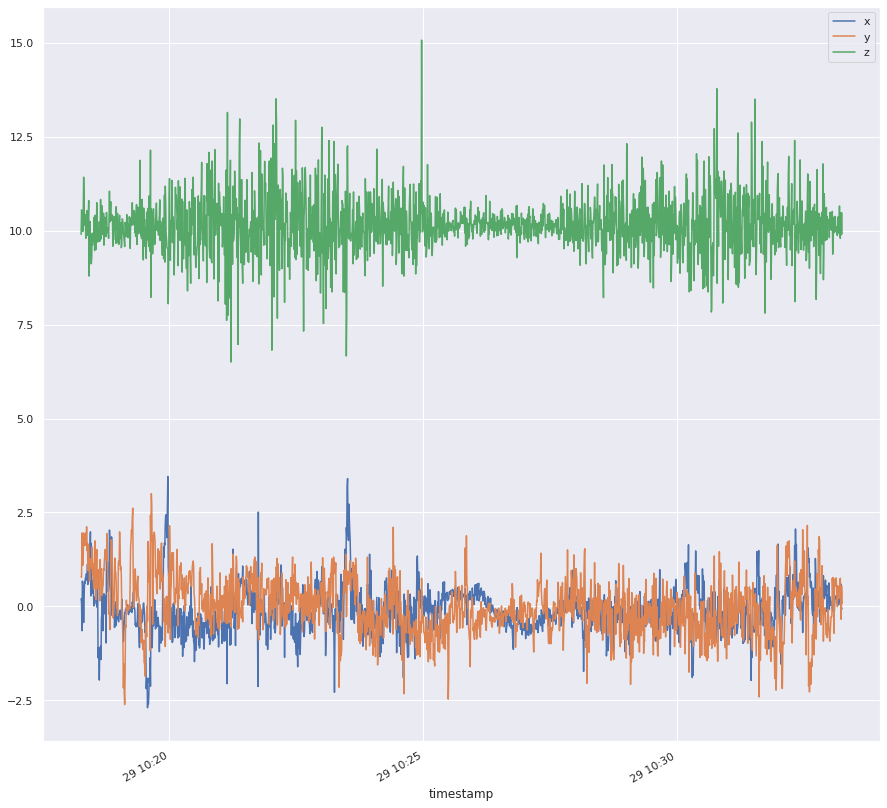

In [0]:
accel.head(1800).plot()

In [0]:
get_trip_duration(accel)

Timedelta('0 days 07:37:19.499000')

In [0]:
e_path = path + "Datasets/Eftekhari Dataset/"
col_names = ["timestamp","x","y","z"]
a_cols = [-1,0,1,2]
g_cols = [-1,9,10,11]

# Read file
data = pd.read_csv("data.csv", header=None)

# Convert timestamp to datetime


NameError: ignored

In [0]:
data.tail()

,0
32060,9;16:38:00.520;42029.69306157407;9.56;-1.195;-...
32061,2;16:38:00.525;42029.693061631944;4.697;9.236;...
32062,4;16:38:00.612;42029.69306263889;-0.006;-0.003...
32063,1;16:38:00.624;42029.69306277778;9.845;-1.225;...
32064,3;16:38:00.625;4202


# Vcar Dataset

In [5]:
vpath = path + "Datasets/vcar/"
col_names = ["timestamp","x","y","z"]

# Read file
data = pd.read_csv(vpath + "data.csv", header=None)

# Convert timestamp to datetime

# Looping over data code
# for _, row in data[6:25].iterrows():
#     line = row[0].split(";")
#     print(line)
# accel_dict = {'timestamp': [], "x": [], "y": [], "z": []}
# gyro_dict = {'timestamp': [], "x": [], "y": [], "z": []}

# time = []
# i = 0
# for _, row in data[6:].iterrows():
#     line = row[0].split(";")
#     if line[0] == "1":
#         accel_dict["timestamp"].append(line[1])
#         accel_dict["x"].append(line[3])
#         accel_dict["y"].append(line[4])
#         accel_dict["z"].append(line[5])
#     elif line[0] == "4":
#         gyro_dict["timestamp"].append(line[1])
#         gyro_dict["x"].append(line[3])
#         gyro_dict["y"].append(line[4])
#         gyro_dict["z"].append(line[5])
#     elif line[0] == "info":
#         print(line)
#         time.append(line[1])

#     i+=1

accel_dict = {'timestamp': [], "x": [], "y": [], "z": []}
gyro_dict = {'timestamp': [], "x": [], "y": [], "z": []}
geo_dict = {"timestamp":[], "s":[]}

time = []
i = 0
for _, row in data[6:].iterrows():
    line = row[0].split(";")
    if line[0] == "1":
        accel_dict["timestamp"].append(float(line[2]))
        accel_dict["x"].append(float(line[3]))
        accel_dict["y"].append(float(line[4]))
        accel_dict["z"].append(float(line[5]))
    elif line[0] == "4":
        gyro_dict["timestamp"].append(float(line[2]))
        gyro_dict["x"].append(float(line[3]))
        gyro_dict["y"].append(float(line[4]))
        gyro_dict["z"].append(float(line[5]))
    elif line[0] == "info":
        print(line)
        time.append(line[1])
    elif line[0] == "geo":
        geo_dict["timestamp"].append(float(line[2]))
        geo_dict["s"].append(float(line[9]))


    i+=1
pd.DataFrame(data = accel_dict,columns=col_names)

['info', '16:29:08.818', '42029.686907615745', 'Start recording', '2015-01-25 16:29:08.820 +0300 (GMT+03:00)']
['info', '16:44:06.434', '42029.69729668982', 'Stop recording', 'Normal stop by user']


,timestamp,x,y,z
0,42029.686923,9.501,-0.956,-0.765
1,42029.686925,9.424,-0.918,-0.842
2,42029.686926,9.500,-0.957,-0.689
3,42029.686928,9.654,-1.071,-0.611
4,42029.686929,9.501,-0.994,-0.688
...,...,...,...,...
7611,42029.697287,9.654,-1.339,-0.458
7612,42029.697288,9.615,-1.340,-0.459
7613,42029.697290,9.731,-1.416,-0.496
7614,42029.697291,9.731,-1.492,-0.573


## Helper Functions

In [0]:
for i in range(1,temp.accel.get_len()):
    if squared_diff(0,i,temp.accel.x,temp.accel.y,temp.accel.z) > 100:
        print(squared_diff(0,i,temp.accel.x,temp.accel.y,temp.accel.z))


In [0]:
    # converting to excel time
    time_thresh /= (24 * 60 * 60) 

    # initialize list of indices
    result = []
    result.append(0)
    end = 0

    for i in range(1, sensor.get_len()) :
        diff = squared_diff(end, i, sensor.x, sensor.y, sensor.z)
        if diff >= threshold or (sensor.t[i] - sensor.t[i-1]) > time_thresh:
            result.append(i)
            end = i
        elif adjacent:
            end = i
    return result

In [0]:
def read_table(file_name):
    """
    read_table(vpath+"data.csv")[-5:]
    """
    table = []
    with open(file_name, "r") as f:
        data = f.readlines()
        for line in data:
            words = line.splitlines()[0].split(';')
            table.append(words)
            
    return table


class Vector:
     x, y, z, len_squared = 0.0, 0.0, 0.0, 0.0

     def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.len_squared = (x * x + y * y + z * z)

     def __lt__(self,Vector):
        return self.len_squared < Vector.len_squared

     def __gt__(self,Vector):
        return self.len_squared > Vector.len_squared

     def __ge__(self,Vector):
        return self.len_squared >= Vector.len_squared

     def __le__(self,Vector):
        return self.len_squared <= Vector.len_squared

def quantile_mean(timestamp, time_list, axis_data, window = 0.5, percent = 0.5):
    """
    This function computes quantile means around a specific timestamp value
    """

    # higher value of windows smooths the data more
    window = window / (24 * 60 * 60)

    # Selects data that lies in defined window
    low_index = bisect.bisect_left(time_list, timestamp - window)
    high_index = bisect.bisect_right(time_list, timestamp + window)
    data = axis_data[low_index: high_index]
    data.sort()

    # Subsetting the window to take a smaller region for smoothing
    n = len(data)
    low = int (math.floor(n * (0.5 * (1 - percent))))
    up =  int (math.ceil(n * (0.5 * (1 + percent))))
    
    if (low == up):
        return 0
    
    if (up - low == 1):
        return data[low]

    # Calculate mean
    total = 0    
    for i in range(low,up):
         total+= data[i]
    
    return total/ (up - low)


def get_means(time_list, axis_data):
    """
    Computes means on varying sized windows of axis_data.
    returns smoothed data
    """
    temp = []
    for timestamp in time_list:
        temp.append(quantile_mean(timestamp,time_list,axis_data))
    return temp


def squared_diff(i, j, x, y, z):
    """
    Computes squared difference between two sensor readings
    """
    
    return np.square(x[j] - x[i]) + np.square(y[j] - y[i]) + np.square(z[j] - z[i])


def get_window_indices(sensor, threshold = 100, time_thresh =3, adjacent = False):
    """
    Creates dynamic sized windows based on threshold values to determine important segments of data.
    time_thresh: defines max window size acceptable (default = 3s).
    """

    # converting to excel time
    time_thresh /= (24 * 60 * 60) 

    # initialize list of indices
    result = []
    result.append(0)
    end = 0

    for i in range(1, sensor.get_len()) :
        diff = squared_diff(end, i, sensor.x, sensor.y, sensor.z)
        if diff >= threshold or (sensor.t[i] - sensor.t[i-1]) > time_thresh:
            result.append(i)
            end = i
        elif adjacent:
            end = i
    return result


def get_rotation_matrix(nx, ny, nz, cos_phi, sin_phi):
    m00 = cos_phi + (1.0 - cos_phi) * nx * nx
    m01 = (1.0 - cos_phi) * nx * ny - sin_phi * nz
    m02 = (1.0 - cos_phi) * nx * nz + sin_phi * ny
    m10 = (1.0 - cos_phi) * ny * nx + sin_phi * nz
    m11 = cos_phi + (1.0 - cos_phi) * ny * ny
    m12 = (1.0 - cos_phi) * ny * nz - sin_phi * nx
    m20 = (1.0 - cos_phi) * nz * nx - sin_phi * ny
    m21 = (1.0 - cos_phi) * nz * ny + sin_phi * nx
    m22 = cos_phi + (1.0 - cos_phi) * nz * nz
    matrix = np.matrix([[m00,m01,m02],[m10,m11,m12],[m20,m21,m22]], dtype=float)
    
    return matrix


def get_z_rotation_matrix(start, end, sensor, part = 0.3):
    """
    Returns matrix that will rotate co-ordinates such that Z points to ground.
    """
    
    # list of class Vector3d
    acc = []
    for i in range(start,end):
        acc.append(Vector3d(sensor.x[i], sensor.y[i], sensor.z[i]))
    
    acc.sort()

    xx = 0.0
    yy = 0.0 
    zz = 0.0
     
    # Setting interval 
    start2 = int (len(acc) * (1 - part) * 0.5)
    end2 = int (len(acc) * (1 + part) * 0.5)
    
    if start2 == end2 :
        start2 = start
        end2 = end

    # Calculates means
    for i in range(start2,end2):
        xx += acc[i].x
        yy += acc[i].y
        zz += acc[i].z

    xx /= end2 - start2
    yy /= end2 - start2
    zz /= end2 - start2


    l1 = np.sqrt(np.square(xx) + np.square(yy) + np.square(zz))
    l2 = np.sqrt(np.square(xx) + np.square(yy))

    if (l1 < 10**-17) or (l2 < 10**-17):
        print ("Small lengths in get_z_rotation_matrix")
        return get_rotation_matrix(0, 0, 1, 1, 0)
    

    nx = yy / l2
    ny = -xx / l2
    nz = 0.0
    cos_phi = zz / l1
    sin_phi = np.sqrt(1 - np.square(cos_phi))

    return get_rotation_matrix(nx, ny, nz, cos_phi, sin_phi)

def get_plane_rotation_matrix(start, end, accel, gyro, geo, speed_thresh = 3):
    """
    Returns rotation matrix with x-axis facing forward
    """

    assert (start < end)
    speed_thres /= (24 * 60 * 60)

    xx = 0.0
    yy = 0.0
    c = 0.0

    for i in range(start,end):

        index_zg = bisect.bisect_left(gyro_z, accel.t[i])
        if index_zg==len(gyro.get_len):
            coeff = 1.0 / (1.0 + np.abs(-416621723))
        else:
            coeff = 1.0 / (1.0 + np.abs(gyro_z[index_zg]))
        speed_index = int (bisect.bisect_left(geo.t, accel.t[i]))

        if (speed_index+1 >= geo.get_len) or (geo.t[speed_index+1]-geo.t[speed_index] > speed_thres) or (geo.speed[speed_index+1] >= geo.speed[speed_index]):
            xx += accel.x[i] * coeff
            yy += accel.y[i] * coeff
        else :
            xx -= accel.x[i] * coeff
            yy -= accel.y[i] * coeff
        
        c += coeff
    
    xx /= c
    yy /= c
    leng = np.sqrt(np.square(xx) + np.square(yy))
    if leng < 10**-17:
        return get_rotation_matrix(0, 0, 1, 1, 0)
    
    xx /= leng
    yy /= leng
    return get_rotation_matrix(0, 0, 1, xx, yy)


def rotate_window(start, end, sensor, mat):
    """
    Rotates co-ordinates. Inplace
    """
    for i in range(start,end):
        x2 = mat[0,0] * sensor.x[i] + mat[0,1] * sensor.y[i] + mat[0,2] * sensor.z[i]
        y2 = mat[1,0] * sensor.x[i] + mat[1,1] * sensor.y[i] + mat[1,2] * sensor.z[i]
        z2 = mat[2,0] * sensor.x[i] + mat[2,1] * sensor.y[i] + mat[2,2] * sensor.z[i]
        sensor.x[i] = x2
        sensor.y[i] = y2
        sensor.z[i] = z2

In [0]:
class Sensor:
    def __init__(self, imu = True):
        if imu:
            self.x = []
            self.y = []
            self.z = []
        else:
            self.speed = []
        self.t = []

    def get_len(self):
        return len(self.t)

    def plot(self):
        plt.plot(self.t,self.x)
        plt.plot(self.t,self.y)
        plt.plot(self.t,self.z)

In [0]:
class Trip:
    def __init__(self,path):
        self.path = path
        self.data = pd.read_csv(path, header=None)
        # removing header
        self.data = self.data[6:]

        self.accel = Sensor()
        self.gyro = Sensor()
        self.magnet = Sensor()
        self.geo = Sensor(False)
        
        self.start_time = None
        self.end_time = None
    
    def read_data(self):
        trip = []
        for _, row in self.data.iterrows():
            line = row[0].split(";")
            
            # Trip duration
            if line[0] == "info":
                trip.append(line[2])

            # Accelerometer
            elif line[0] == "1":
                self.accel.t.append(float(line[2]))
                self.accel.x.append(float(line[3]))
                self.accel.y.append(float(line[4]))
                self.accel.z.append(float(line[5]))

            elif line[0] == "2":
                self.magnet.t.append(float(line[2]))
                self.magnet.x.append(float(line[3]))
                self.magnet.y.append(float(line[4]))
                self.magnet.z.append(float(line[5]))

            # Gyroscope
            elif line[0] == "4":
                self.gyro.t.append(float(line[2]))
                self.gyro.x.append(float(line[3]))
                self.gyro.y.append(float(line[4]))
                self.gyro.z.append(float(line[5]))
            
            elif line[0] == "geo":
                self.geo.t.append(float(line[2]))
                self.geo.speed.append(float(line[9]))

        self.start_time = time[0]
        self.end_time = time[1]
        # pd.DataFrame(data = accel_dict,columns=col_names)

    def get_duration():
        return self.end_time - self.end_time

    def compute_means(self,sensor):
        temp = Sensor()

        if sensor == 'a':
            temp.x = get_means(self.accel.t,self.accel.x)
            temp.y = get_means(self.accel.t,self.accel.y)
            temp.z = get_means(self.accel.t,self.accel.z)
            temp.t = self.accel.t

        elif sensor == 'g':
            temp.x = get_means(self.gyro.t,self.gyro.x)
            temp.y = get_means(self.gyro.t,self.gyro.y)
            temp.z = get_means(self.gyro.t,self.gyro.z)
            temp.t = self.gyro.t
        return temp

    #*********#
    # FILTERS #
    #*********#
            
    def kalman_filter(self,sensor):
        """
        Applies Kalman Filter to axis data. Use when sensors are already re-oriented.
        sensor values = 'a' or 'g'
        *returns a pandas Series
        """
        output = []
        if sensor == "a":
            axes = (self.accel.x,self.accel.y,self.accel.z)
            time = self.accel.t
            means = [0,0,9.7]

        elif sensor == "g":
            axes = (self.gyro.x,self.gyro.y,self.gyro.z)
            time = self.gyro.t
            means = [0,0,0]
        else:
            print("Valid arguments are 'a' or 'g'")
            return

        for i in range(3):
            kf = KalmanFilter(transition_matrices = [1],
                                    observation_matrices = [1],
                                    initial_state_mean = means[i],
                                    initial_state_covariance = 1.1,
                                    observation_covariance=0.8,
                                    transition_covariance=.07)
            state_means,_ = kf.filter(axes[i])
            state_means = pd.Series(state_means.flatten(), index=time)
            output.append(state_means)
        return output


    def smooth_filter(self, sensor, window_size = 3): 
        """
        Applies smoothing sliding window filter
        """
        smooth_data = Sensor()

        if sensor == 'a':
            if self.accel.x != []:
                for i in range(self.accel.get_len()):
                    frame = i - window_size
                    if frame < 0:
                        frame = 0
                    sums = [0,0,0]
                    count = 1

                    # Ensure that only those frame are considered that lie in the window
                    while frame <= i + window_size and frame <self.accel.get_len():
                        sums[0] += self.accel.x[frame]
                        sums[1] += self.accel.y[frame]
                        sums[2] += self.accel.z[frame]
                        frame += 1
                        count += 1

                    # Assigning final data
                    smooth_data.x.append(sums[0]/count)
                    smooth_data.y.append(sums[1]/count)
                    smooth_data.z.append(sums[2]/count)
                smooth_data.t = self.accel.t
                return smooth_data
        
        elif sensor == 'g':
            if self.gyro.x != []:
                for i in range(self.gyro.get_len()):
                    frame = i - window_size
                    if frame < 0:
                        frame = 0
                    sums = [0,0,0]
                    count = 1

                    # Ensure that only those frame are considered that lie in the window
                    while frame <= i + window_size and frame <self.gyro.get_len():
                        sums[0] += self.gyro.x[frame]
                        sums[1] += self.gyro.y[frame]
                        sums[2] += self.gyro.z[frame]
                        frame += 1
                        count += 1

                    # Assigning final data
                    smooth_data.x.append(sums[0]/count)
                    smooth_data.y.append(sums[1]/count)
                    smooth_data.z.append(sums[2]/count)
                smooth_data.t = self.gyro.t
                return smooth_data
        else:
            print("Valid arguments are 'a' or 'g'")

    def complementary_filter(self):

        # Smoothing Data
        accel = self.smooth_filter('a')
        gyro = self.smooth_filter('g')


        RAD_TO_DEG = 180/3.14159

        output = Sensor()
        old_angx = [0.0]
        old_angy = [0.0]
        old_angz = [0.0]

        min_len = min(accel.get_len(), gyro.get_len())

        for i in range(min_len):

            # Smoothed Accleration values
            a_t = accel.t[i]
            a_x = accel.x[i]
            a_y = accel.y[i]
            a_z = accel.z[i]

            # Caclulating angles from accelerometer data
            a_angx = np.arctan(a_y / np.sqrt(np.power(a_x,2) + np.power(a_z,2))) * RAD_TO_DEG
            a_angy = np.arctan(-1 * a_x / np.sqrt(np.power(a_y,2) + np.power(a_z,2))) * RAD_TO_DEG
            a_angz = 0


            # Smoothed Gyroscope values
            g_x = gyro.x[i]
            g_y = gyro.y[i]
            g_z = gyro.z[i]
            g_t = gyro.t[i]
            

            # Computing drifting gyro angles (filtered)
            dt = 0.12       #dt=120ms
            g_angx = g_x * dt + old_angx[-1]
            g_angy = g_y * dt + old_angy[-1]
            g_angz = g_z * dt + old_angz[-1]

            # Applying complimentary filter 
            alpha = 0.96        # depends on sampling rate
            angx = alpha * g_angx + (1.0 - alpha) * a_angx
            angy = alpha * g_angy + (1.0 - alpha) * a_angy
            angz = g_angz

            # Updating old angles
            old_angx.append(angx)
            old_angy.append(angy)
            old_angz.append(angz)


            # Appending values to ouput sensor
            output.x.append(angx)
            output.y.append(angy)
            output.z.append(angz)
            output.t.append((a_t + g_t)/2.0)

        # Returns sensor-fused data (accel + gyro)
        return output

    # def filter_data(data):

    #     aAcc = []
    #     aGyr = []
    #     aGeo = []
    #     result = []

    #     for _, row in data[6:].iterrows():
    #         line = row[0].split(";")
    #         if line[0] == "1":
    #             line[2] = float(line[2])
    #             line[3] = float(line[3])
    #             line[4] = float(line[4])
    #             line[5] = float(line[5])
    #             aAcc.append(line)

    #         elif line[0] == "4":
    #             line[2] = float(line[2])
    #             line[3] = float(line[3])
    #             line[4] = float(line[4])
    #             line[5] = float(line[5])
    #             aGyr.append(line)

    #         elif line[0] == "geo":
    #             line[2] = float(line[2])
    #             line[9] = float(line[9])
    #             aGeo.append(line)

    #     result = result + aGeo

    #     filter_proc(np.array(aAcc), [3,4,5], result, [0,0,9.6])
    #     filter_proc(np.array(aGyr), [3,4,5], result, [0,0,0])
    #     return result

            

    # def smooth_data(self, table, ta, xa, ya, za, tg, xg, yg, zg, tmag, xmag, ymag, zmag, do_cf):
    #     ia = 0
    #     im = 0
    #     ig = 0
    #     i = 0

    #     aAcc = []
    #     aMag = []
    #     aGyr = []
    #     aGeo = []
    #     result = []

    #     if do_cf:
    #         self.ComplementaryFilter(aAcc, aGyr, result)

        return result
              

    def dumb_track_calculation(self, ta, xa, ya, tg, zg, x, y, start = 0):
        x_cur = 0.0
        y_cur = 0.0
        alpha_cur = 0.0
        vx_cur = 0.0
        vy_cur = 0.0
        
        for i in xrange(start):
            x.append(0)
            y.append(0)
        
        j = 0
        for i in xrange(start, len(ta)-1):
            while j < len(zg)-1 and tg[j+1] < ta[i] :
                alpha_cur = alpha_cur + zg[j] * (tg[j+1] - tg[j])
                print (alpha_cur, ' ', j, ' ', zg[j], ' ', tg[j + 1], ' ', tg[j])
                j = j + 1
            
            dt = ta[i+1] - ta[i];
            ax_cur = xa[i] * np.cos(alpha_cur) + ya[i] * np.sin(alpha_cur)
            ay_cur = -xa[i] * np.sin(alpha_cur) + ya[i] * np.cos(alpha_cur)
            vx_cur = vx_cur + ax_cur * dt
            vy_cur = vy_cur + ay_cur * dt
            x_cur = x_cur + vx_cur * dt
            y_cur = y_cur + vy_cur * dt
            x.append(x_cur)
            y.append(y_cur)
            
            
    def normalizer(self):

        self.read_data()

        accel_means = self.compute_means('a')
        indices = get_window_indices(accel_means)
        
        print (len(indices), " windows(s) found\n")

        for i in range(len(indices)):
            start = indices[i]

            
            if i < len(indices) - 1 :
                finish = indices[i + 1]
            else:
                finish = accel_means.get_len()
            

            # Get the rotation matrix as return type
            rot_matrix = get_z_rotation_matrix(start, finish, accel_means)
            # Applies rotation matrix on the the mean values of accelerometer data
            rotate_block(start, finish, accel_means, rot_matrix)

            # BISECTS 
            start2 = int ( bisect.bisect_left(self.gyro.t, self.accel[indices[i]]))
            if i < len(indices)-1 :
                finish2 = int ( bisect.bisect_left(self.gyro.t, self.accel.t[indices[i + 1]]) )
            else:
                finish2 = self.gyro.get_len()

            rotate_block(start2, finish2, self.gyro, rot_matrix)

            #A verifier les parametres rot_matrix2
            rot_matrix2 = get_plane_rotation_matrix(start, finish, self.accel, self.gyro, self.geo)
            
            rotate_block(start, finish, accel_means, rot_matrix2)
            rotate_block(start2, finish2, self.gyro, rot_matrix2)
            rotate_block(start, finish, self.excel, rot_matrix)
            rotate_block(start, finish, self.excel, rot_matrix2)

            start3 = int ( bisect.bisect_left(self.magnet.t, self.accel.t[indicess[i]]) )
            if i < len(indicess)-1 :
                finish3 = int ( bisect.bisect_left(self.magnet.t, self.accel.t[indicess[i + 1]]) )
            else:
                finish3 = self.magnet.get_len()
            rotate_block(start3, finish3, self.magnet, rot_matrix)
            rotate_block(start3, finish3, self.magnet, rot_matrix2)
                    
        return 

## Normalizing using different Filters

In [0]:
temp = Trip(vpath + "data.csv")
temp.read_data()

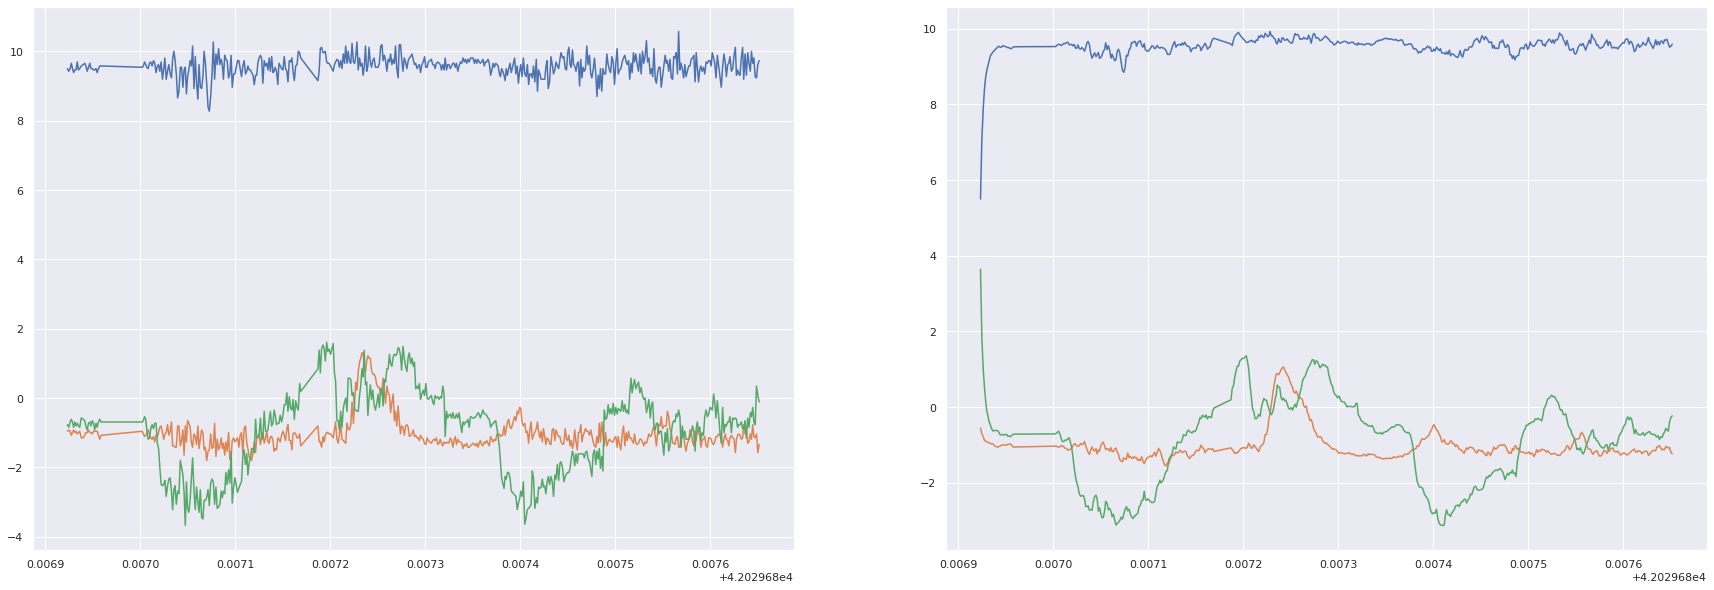

In [42]:
k = temp.kalman_filter('a')
plt.figure(figsize=(30,10))
plt.subplot(121)

plt.plot(temp.accel.t[:500],temp.accel.x[:500])
plt.plot(temp.accel.t[:500],temp.accel.y[:500])
plt.plot(temp.accel.t[:500],temp.accel.z[:500])

plt.subplot(122)

plt.plot(k[0].iloc[:500])
plt.plot(k[1].iloc[:500])
plt.plot(k[2].iloc[:500])


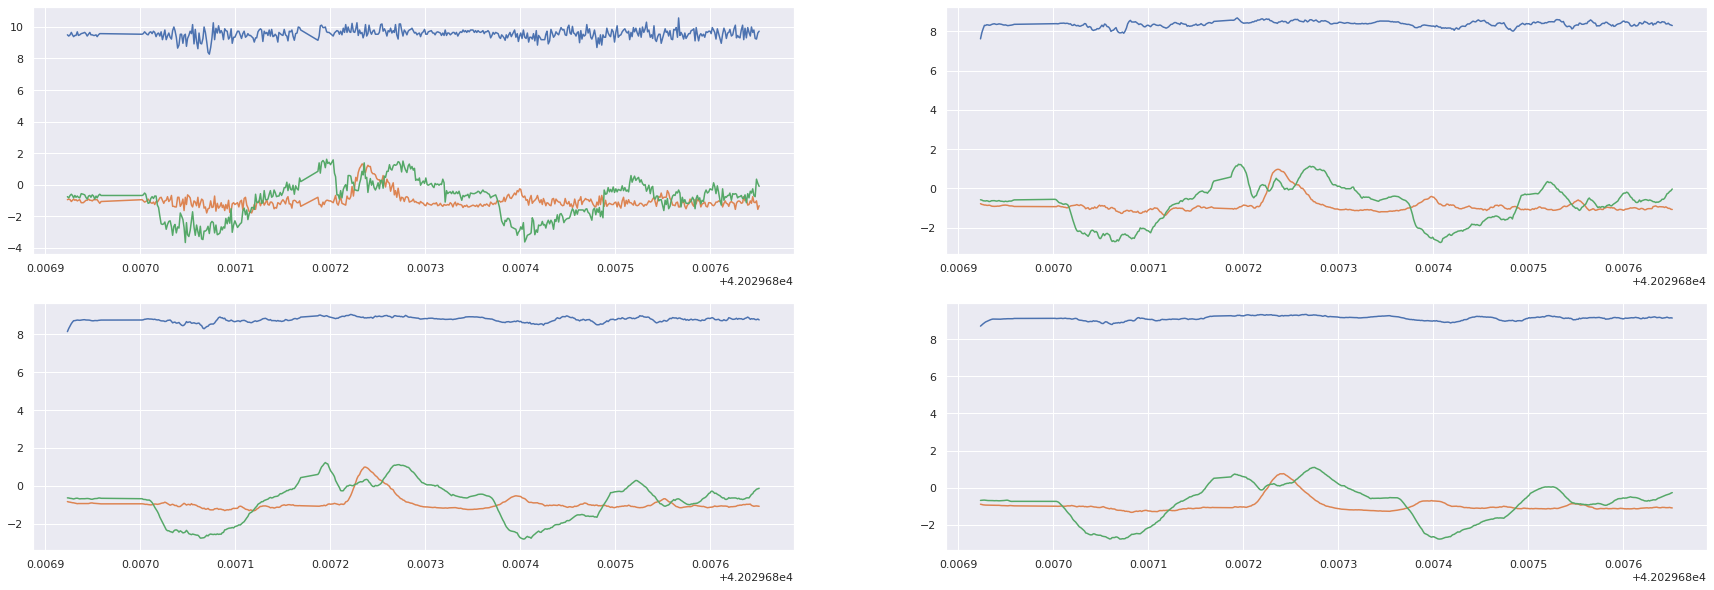

In [45]:
fig = plt.figure(figsize=(30,10))
plt.subplot(221)
plt.plot(temp.accel.t[:500],temp.accel.x[:500])
plt.plot(temp.accel.t[:500],temp.accel.y[:500])
plt.plot(temp.accel.t[:500],temp.accel.z[:500])
plt.subplot(222)

# window size 3
s = temp.smooth_filter('a',3)
plt.plot(s.t[:500],s.x[:500])
plt.plot(s.t[:500],s.y[:500])
plt.plot(s.t[:500],s.z[:500])

# window size 5
plt.subplot(223)
s = temp.smooth_filter('a',5)
plt.plot(s.t[:500],s.x[:500])
plt.plot(s.t[:500],s.y[:500])
plt.plot(s.t[:500],s.z[:500])

# window size 10
plt.subplot(224)
s = temp.smooth_filter('a',10)
plt.plot(s.t[:500],s.x[:500])
plt.plot(s.t[:500],s.y[:500])
plt.plot(s.t[:500],s.z[:500])


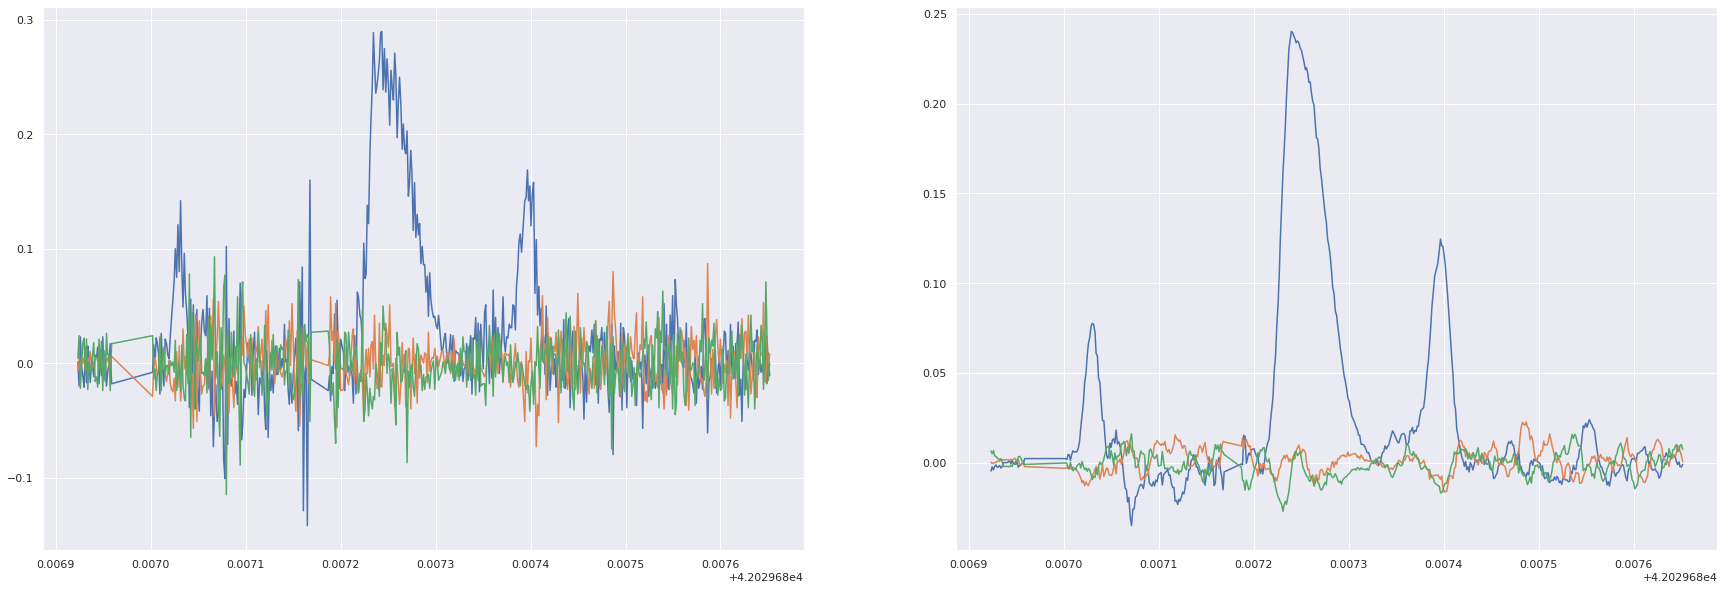

In [0]:
s = temp.smooth('g',5)
fig = plt.figure(figsize=(30,10))
plt.subplot(121)
plt.plot(gyro_dict["timestamp"][:500],gyro_dict["x"][:500])
plt.plot(gyro_dict["timestamp"][:500],gyro_dict["y"][:500])
plt.plot(gyro_dict["timestamp"][:500],gyro_dict["z"][:500])
plt.subplot(122)

plt.plot(s.t[:500],s.x[:500])
plt.plot(s.t[:500],s.y[:500])
plt.plot(s.t[:500],s.z[:500])


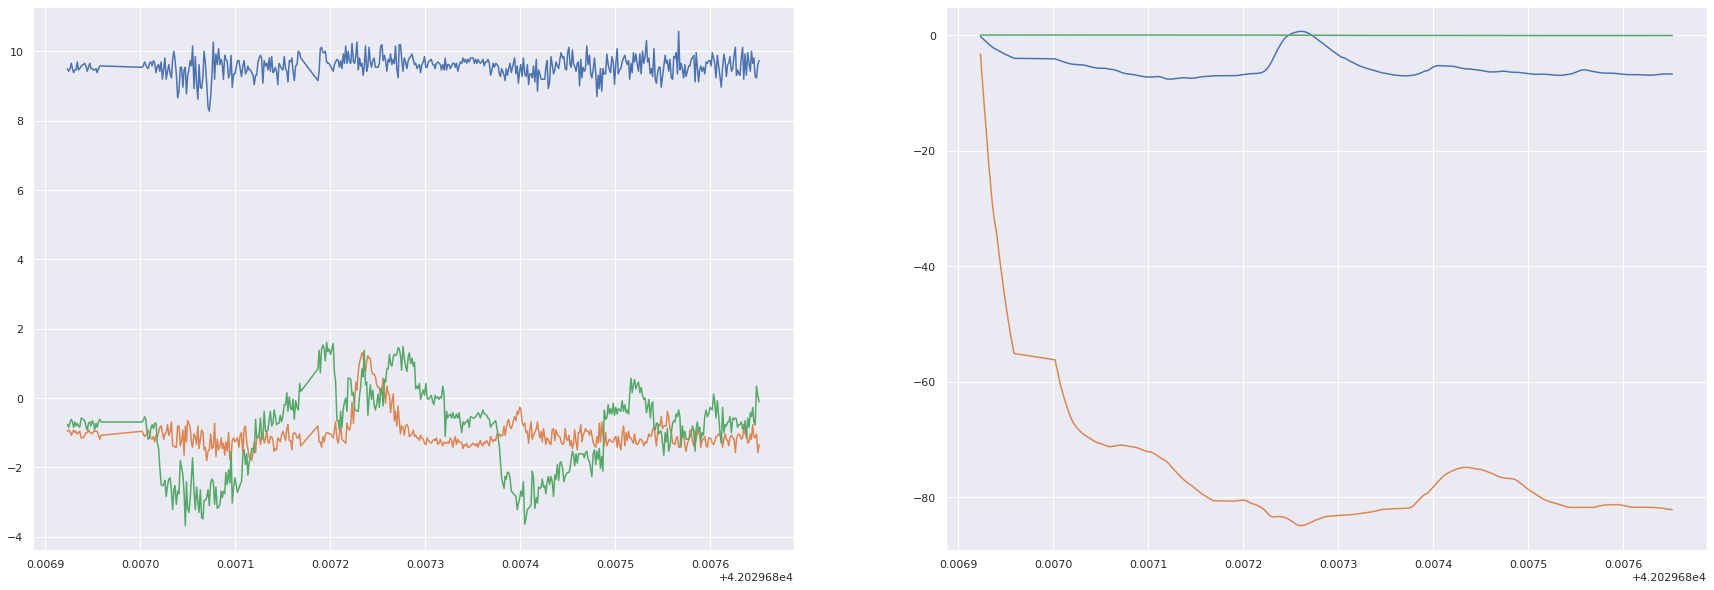

In [0]:
fig = plt.figure(figsize=(30,10))
plt.subplot(121)
plt.plot(x.iloc[:500])
plt.plot(y.iloc[:500])
plt.plot(z.iloc[:500])
plt.subplot(122)

c = temp.complementary_filter()
plt.plot(c.t[:500],c.x[:500])
plt.plot(c.t[:500],c.y[:500])
plt.plot(c.t[:500],c.z[:500])
